In [ ]:
#from google.colab import files
# files.upload()

In [ ]:
# !pip install -q kaggle

# # إنشاء مجلد .kaggle ونقل ملف API إليه
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # تحميل داتا Titanic
# !kaggle competitions download -c titanic

# # فك الضغط
# !unzip titanic.zip

In [19]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
# تحميل البيانات
train = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# PassengerId	int	رقم معرف فريد لكل راكب
# Survived	int (0 أو 1)	هل نجا الراكب؟ (1 = نجا، 0 = مات) → هذا هو الهدف (label).
# Pclass	int (1, 2, 3)	الدرجة الاجتماعية للراكب:
# 1 = الدرجة الأولى (أغلى)،
# 2 = الثانية،
# 3 = الثالثة (أرخص).
# Name	str	اسم الراكب الكامل، يحتوي غالبًا على اللقب مثل Mr. أو Dr.
# Sex	str ("male" / "female")	جنس الراكب (مهم جدًا للتنبؤ).
# Age	float	عمر الراكب (بعض القيم مفقودة).
# SibSp	int	عدد الإخوة/الأخوات أو الأزواج/الزوجات الذين كانوا مع الراكب على متن السفينة.
# Parch	int	عدد الآباء/الأمهات أو الأبناء الذين كانوا مع الراكب.
# Ticket	str	رقم التذكرة (غير مفيد في شكله الخام غالبًا).
# Fare	float	المبلغ الذي دفعه الراكب (التكلفة).
# Cabin	str	رقم الكابينة
# Embarked	str (C, Q, S)	الميناء الذي ركب منه الراكب:
# C = Cherbourg, Q = Queenstown, S = Southampton.

# Title	لقب الراكب المأخوذ من اسمه (مثل: Mr, Miss, Dr)
# FamilySize	عدد أفراد العائلة على السفينة = SibSp + Parch + 1
# IsAlone	1 إذا كان الراكب بمفرده، 0 إذا كان معه عائلة
# Deck	الطابق المستخرج من أول حرف في Cabin

In [4]:
print(train.info())
print(train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int6

In [7]:
print(f"Train shape: {train.shape}")

Train shape: (891, 12)


In [9]:
train['Title'] = train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

In [10]:
train['Title'].value_counts()

,count
Title,
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Col,2
Mlle,2
Major,2


In [11]:
#replace rare with rare_titles
rare_titles = ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev',
               'Sir', 'Jonkheer', 'Dona']
train['Title'] = train['Title'].replace(rare_titles, 'Rare')

In [12]:
train['Title'] = train['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

In [13]:
# تحويلها إلى أرقام
train['Title'] = train['Title'].astype('category').cat.codes

In [14]:
import numpy as np
# حجم العائلة
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

# هل الشخص وحيد؟
train['IsAlone'] = (train['FamilySize'] == 1).astype(int)

# استخراج Deck من Cabin
train['Deck'] = train['Cabin'].astype(str).str[0]
train['Deck'] = train['Deck'].replace('n', np.nan)
train['Deck'] = train['Deck'].astype('category').cat.codes

In [16]:
# Age: ملء القيم الناقصة بمتوسط العمر حسب اللقب
train['Age'] = train.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

# Embarked: ملء القيم الناقصة بالقيمة الأكثر تكرارًا
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
# Fare: ملء بقيمة الوسيط
train['Fare'] = train['Fare'].fillna(train['Fare'].median())

# تحويل Embarked إلى أرقام
train['Embarked'] = train['Embarked'].astype('category').cat.codes

# تحويل Sex إلى أرقام
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})

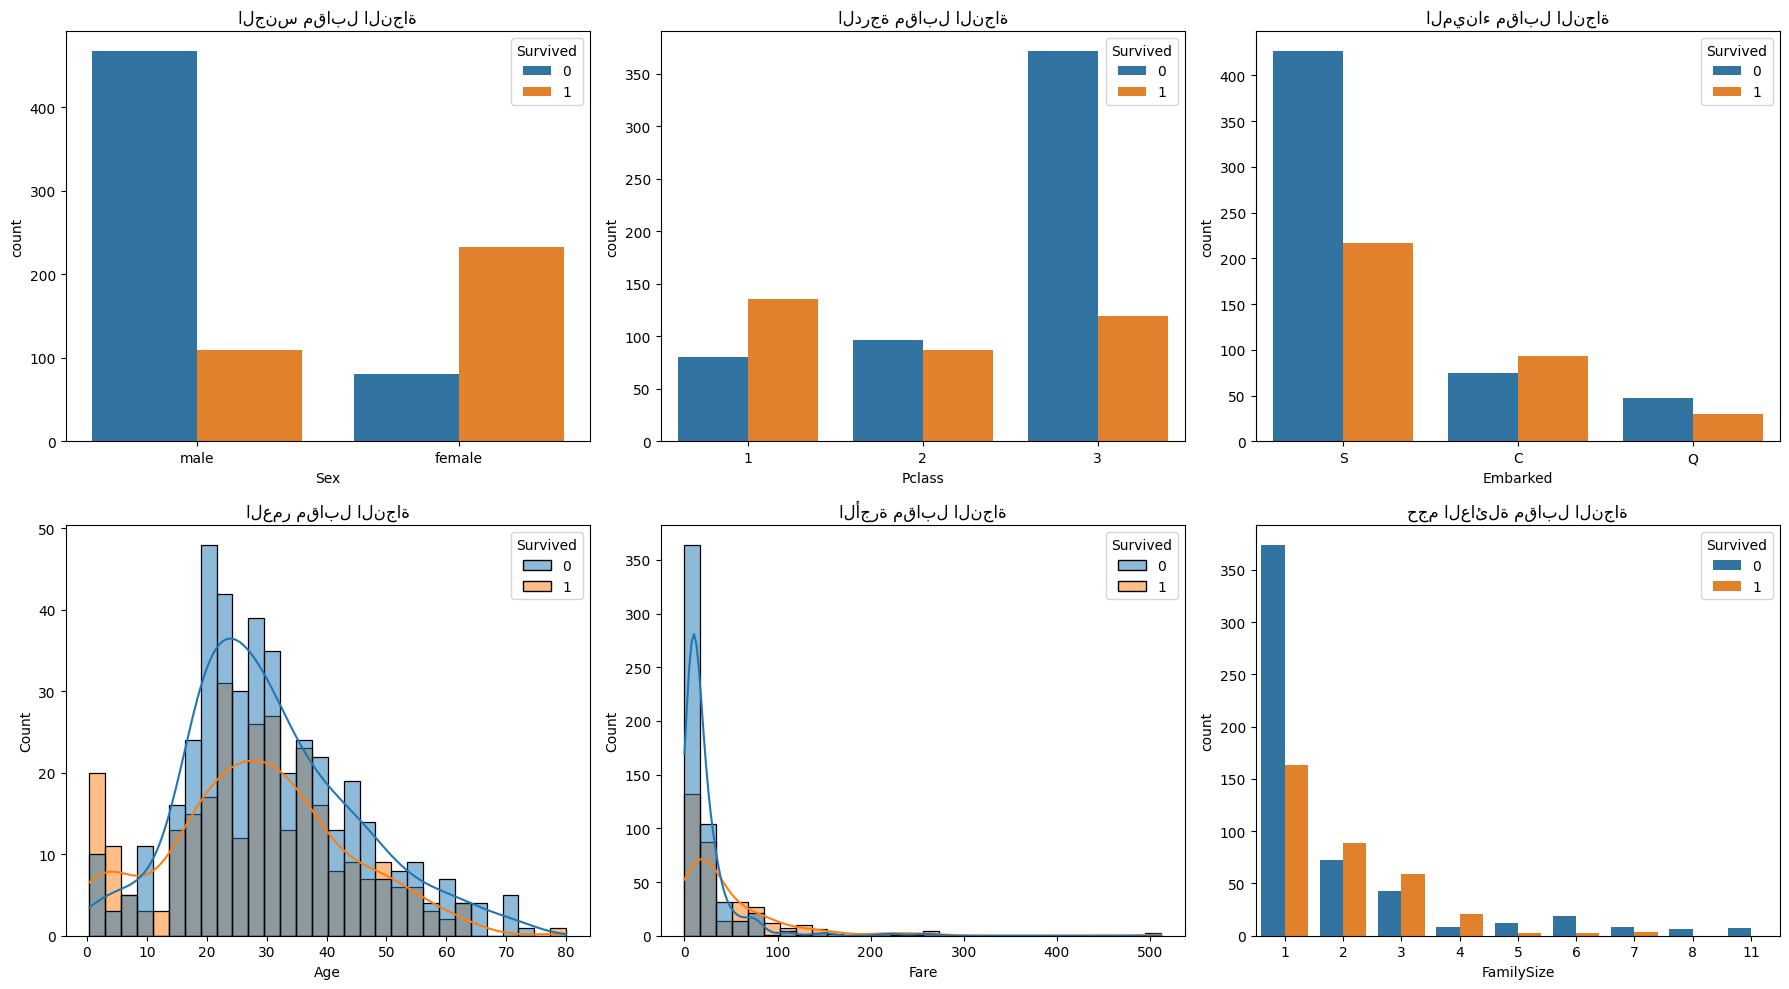

In [29]:
plt.rcParams['font.family'] = 'DejaVu Sans'


fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# الجنس مقابل النجاة
sns.countplot(data=train, x='Sex', hue='Survived', ax=axs[0, 0])
axs[0, 0].set_title('الجنس مقابل النجاة')

# الدرجة مقابل النجاة
sns.countplot(data=train, x='Pclass', hue='Survived', ax=axs[0, 1])
axs[0, 1].set_title('الدرجة مقابل النجاة')

# الميناء مقابل النجاة
sns.countplot(data=train, x='Embarked', hue='Survived', ax=axs[0, 2])
axs[0, 2].set_title('الميناء مقابل النجاة')

# توزيع العمر حسب النجاة
sns.histplot(data=train, x='Age', hue='Survived', bins=30, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('العمر مقابل النجاة')

# توزيع الأجرة حسب النجاة
sns.histplot(data=train, x='Fare', hue='Survived', bins=30, kde=True, ax=axs[1, 1])
axs[1, 1].set_title('الأجرة مقابل النجاة')

# FamilySize مقابل النجاة
sns.countplot(data=train, x='FamilySize', hue='Survived', ax=axs[1, 2])
axs[1, 2].set_title('حجم العائلة مقابل النجاة')

plt.tight_layout()
plt.show()

In [17]:
train.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'], inplace=True)

In [18]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = train[features]
y = train['Survived']

In [20]:
# تقسيم الأعمدة
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# المعالجات الرقمية
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# المعالجات الفئوية
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# دمج المعالجات في ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# النموذج داخل Pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# تدريب النموذج
clf.fit(X_train, y_train)

# التقييم
print("Train Accuracy:", clf.score(X_train, y_train))
print("Test Accuracy:", clf.score(X_test, y_test))

Train Accuracy: 0.9775280898876404
Test Accuracy: 0.8324022346368715


In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 5, 10],
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# اختبار النموذج الأفضل
print("Test accuracy after tuning:", grid_search.score(X_test, y_test))

Best parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Best cross-validation accuracy: 0.8229981286319316
Test accuracy after tuning: 0.8324022346368715


In [23]:
import joblib

# حفظ النموذج
joblib.dump(clf, 'titanic_clf_model.pkl')

# لتحميل النموذج لاحقًا
loaded_model = joblib.load('titanic_clf_model.pkl')

# اختبار النموذج المحفوظ
print("Test accuracy with loaded model:", loaded_model.score(X_test, y_test))

Test accuracy with loaded model: 0.8324022346368715
